# Tutorial for REU data processing and visualization

##### Authors: Yu Huang, Sungduk Yu

It is an introductory tutorial for a demo dataset from the climate model [E3SM-MMF](https://www.exascaleproject.org/research-project/e3sm-mmf/). See [E3SM](https://e3sm.org/wp-content/uploads/2021/11/E3SM_Brochure-2021.pdf) for more information.

This notebook includes preprocessing of the unstructured data, which cannot be managed by xarray directly, and visualization of climate variables. 

The goal is to practice the skills covered during Week1 of the bootcamp to make climate analysis, and to get more familiar with the climate concepts.


#### If Git
either type *gh-scoped-creds* in terminal

In [51]:
# or run this
import gh_scoped_creds
%ghscopedcreds

<IPython.core.display.Javascript object>

The code 055A-6AF5 has been copied to your clipboard.
You have 15 minutes to go to https://github.com/login/device and paste it there.

Waiting.............


Visit https://github.com/apps/leap-hub-push-access to manage list of repositories you can push to from this location
Tip: Use https:// URLs to clone and push to repos, not ssh URLs!


## Install and load python packages

#### Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install pynco pynio pyngl

In [2]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from nco import Nco
from tqdm import tqdm
import Ngl

## Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [3]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [4]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


In [5]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')


#### Which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).


In [6]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 ...
    cam_out_NETSW   (sample, ncol) float64 ...
    cam_out_PRECC   (sample, ncol) float64 ...
    cam_out_PRECSC  (sample, ncol) float64 ...
    cam_out_SOLL    (sample, ncol) float64 ...
    cam_out_SOLLD   (sample, ncol) float64 ...
    ...              ...
    state_q0003     (sample, lev, ncol) float64 ...
    state_t         (sample, lev, ncol) float64 ...
    state_u         (sample, lev, ncol) float64 ...
    state_v         (sample, lev, ncol) float64 ...
    tod             (sample) int32 ...
    ymd             (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

## Reorganize the dimensions/coordinates

### Add the *time* dimension  
Originally the time information is coded in the variables **ymd** and **tod**. The **sample** index represents the time step count. 

**ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.

**tod** represents time in the day counted in seconds.

In [7]:
ds.ymd.values[0], ds.tod.values[0]

(10201, 0)

In [8]:
# loop over all sample points
year=ds['ymd']//10000
month=ds['ymd']%10000//100
day=ds['ymd']%10000%100
hour=ds['tod']//3600
minute=ds['tod']%3600//60

k=0
t = []
for k in range(len(ds['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds['sample'] = t
ds = ds.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds = ds.drop(['tod','ymd'])

# Check the current **time** dimension, read the timestep
ds.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

### Reduce the data size/coarse the time resolution 

The **time** dimension is large. For simplicity, currently we'll keep only one sample each day. 

You can take the daily/monthly mean/max/min data or the data at a specific time each day. 

For example, here I only keep the data at noon each day cuz it is faster to run. There are many ways to do that.

In [9]:
itime = np.arange(36,len(ds.time),24*3)
ds = ds.isel(time = itime)
ds

<xarray.Dataset>
Dimensions:         (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
Dimensions without coordinates: ncol, lev
Data variables: (12/14)
    cam_out_FLWDS   (time, ncol) float64 ...
    cam_out_NETSW   (time, ncol) float64 ...
    cam_out_PRECC   (time, ncol) float64 ...
    cam_out_PRECSC  (time, ncol) float64 ...
    cam_out_SOLL    (time, ncol) float64 ...
    cam_out_SOLLD   (time, ncol) float64 ...
    ...              ...
    state_q0001     (time, lev, ncol) float64 ...
    state_q0002     (time, lev, ncol) float64 ...
    state_q0003     (time, lev, ncol) float64 ...
    state_t         (time, lev, ncol) float64 ...
    state_u         (time, lev, ncol) float64 ...
    state_v         (time, lev, ncol) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

I can continue taking the monthly mean using *resample* function, which will further reduce the data size. It requires more memory so I will only process two 2D
variables.

In [10]:
# first we do a bit transformation
ds['cam_out_PRECT'] = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']
ds = ds[['cam_out_PRECT', 'cam_out_FLWDS']].resample(time='1M').mean(dim='time')


In [28]:
ds

<xarray.Dataset>
Dimensions:        (time: 96, ncol: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: ncol
Data variables:
    cam_out_PRECT  (time, ncol) float64 5.168e-09 1.387e-08 ... 4.404e-08
    cam_out_FLWDS  (time, ncol) float64 383.8 367.7 412.6 ... 195.9 242.4 254.0
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Reshape and interpolate the data so that they have structured lat, lon coordinates

#### Open a file that stores grid information, and check the original lat, lon information

In [11]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

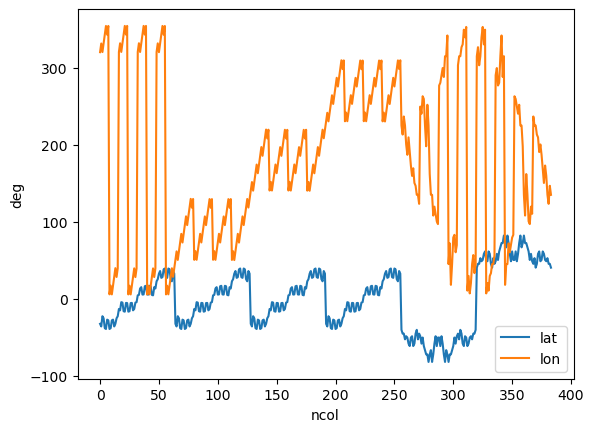

In [12]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [13]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) and see what the data looks like

Here I use two precipitation and radiation variables as an example for plotting.

In [14]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# set multi-index for the original dataset using lat and lon
ds_multiindex = ds_multiindex.set_index(index_id=["lat", "lon"])
index_id = ds_multiindex.index_id
ds_multiindex = ds_multiindex.drop('index_id')
ds_multiindex = ds_multiindex.rename({'ncol':'index_id'})
ds_multiindex = ds_multiindex.assign_coords(index_id = index_id)
ds_multiindex

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat            (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
  * lon            (index_id) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
  * index_id       (index_id) object MultiIndex
Data variables:
    cam_out_PRECT  (time, index_id) float64 5.168e-09 1.387e-08 ... 4.404e-08
    cam_out_FLWDS  (time, index_id) float64 383.8 367.7 412.6 ... 242.4 254.0
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [18]:
# create a dataset with stacked (lat, lon) grids in the original dataset, all values are NaNs
time = ds.time.values

data_np = np.empty(shape=(len(time), len(np.unique(lat)),len(np.unique(lon))))
data_np[:,:] = np.nan

ds_latlon = xr.Dataset(
     data_vars={
         # v: (("time","index_id"), np.zeros([len(time), len(np.unique(lat))*len(np.unique(lon))]))
         v: (("time","lat","lon"), data_np)
         for v in ['cam_out_FLWDS','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         # "index_id": pd.MultiIndex.from_product(
         #    [np.unique(lat), np.unique(lon)], names=["lat", "lon"],),
         "lat": np.unique(lat),
         "lon": np.unique(lon),
         # "lev": ds.lev,
    },
)

# use multi-index so that we can assign the column data to the (lat,lon) data
ds_latlon = ds_latlon.stack(index_id=['lat','lon'])
ds_latlon 

# print(len(ds_multiindex.index_id.values))
# ds_latlon.sel(index_id=(-32.59, 320.27))

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 9360)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * index_id       (index_id) object MultiIndex
  * lat            (index_id) float64 -82.06 -82.06 -82.06 ... 82.06 82.06 82.06
  * lon            (index_id) float64 5.63 5.65 5.68 5.73 ... 354.3 354.4 354.4
Data variables:
    cam_out_FLWDS  (time, index_id) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECT  (time, index_id) float64 nan nan nan nan ... nan nan nan nan

100%|██████████| 384/384 [00:00<00:00, 598.82it/s]


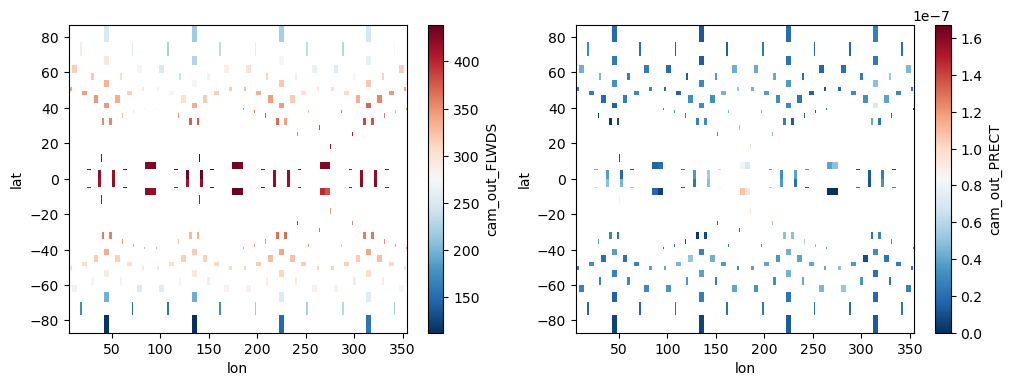

In [20]:
# use tqdm to visualize the progress of the below loop
# this cell takes about 20min to run, please patiently wait when it is run
ds_precc = ds_latlon.cam_out_PRECT.copy()
ds_flwds = ds_latlon.cam_out_FLWDS.copy()

for i in tqdm(ds_multiindex.index_id.values):
    # ds_latlon.loc[{"index_id": i}] = ds_multiindex[['cam_out_FLWDS','cam_out_PRECC']].sel(index_id = i) 
    #### wrong, will lead to all vars have the same values
    ds_precc.loc[{"index_id": i}] = ds_multiindex['cam_out_PRECT'].sel(index_id = i)
    ds_flwds.loc[{"index_id": i}] = ds_multiindex['cam_out_FLWDS'].sel(index_id = i)

ds_latlon['cam_out_PRECT'] = ds_precc.copy()
ds_latlon['cam_out_FLWDS'] = ds_flwds.copy()

ds_unstack = ds_latlon.unstack('index_id')
ds_unstack

## if we directly visualize the 2D maps, then there are many missing values 
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_unstack.cam_out_FLWDS.mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_unstack.cam_out_PRECT.mean('time').plot(cmap='RdBu_r',ax=ax[1])

##### <span style="color:blue"> Look, the raw dataset is visualized weirdly directly using xarray because it is on an unstructured grid. See [page 9](https://www.osti.gov/servlets/purl/1807356) to know more about the raw grid setup.</span>

#### Use [pynco](https://pynco.readthedocs.io/en/stable/) to remap data on the unstructured grid to a structured grid 

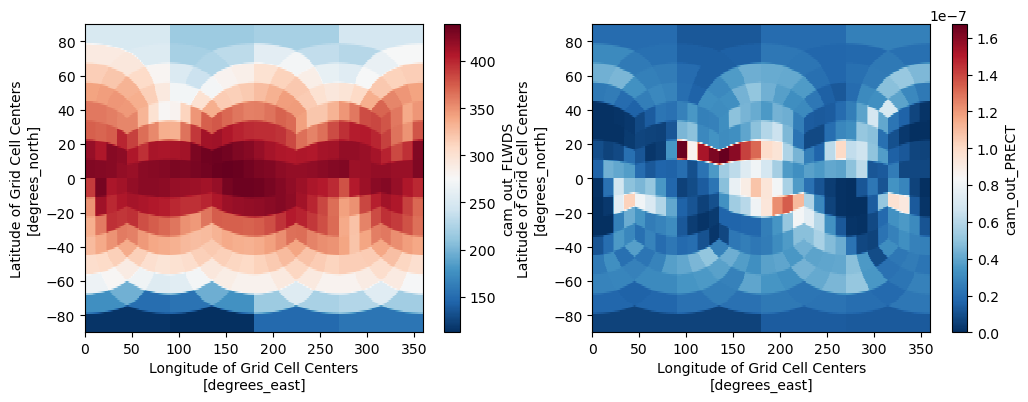

In [48]:
infile = './E3SM-MMF_ne4_train_output_monthly_raw.nc'
outfile = './E3SM-MMF_ne4_train_output_monthly_remap.nc'
#Mapfile to convert unstructured data to gridded data
mapfile = '../map_ne4pg2_to_180x360_aave.20220722.nc'

ds.to_netcdf('./E3SM-MMF_ne4_train_output_monthly_raw.nc')

nco = Nco()
nco.ncks(input=infile, output=outfile, map=mapfile)

ds_remap = xr.open_dataset(outfile)

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_remap['cam_out_FLWDS'].mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_remap['cam_out_PRECT'].mean('time').plot(cmap='RdBu_r',ax=ax[1])

It still looks weird. 
## <span style="color:blue">Did I made it wrong?</span>

#### Interpolate the unstructured data at 2-deg resolution

For simplicity and memory consideration, we use a tool [PyNGL](https://www.pyngl.ucar.edu/Functions/Ngl.natgrid.shtml) to interpolate the data to make it structured on the grid we want, so that we can make some climate analysis using the skills you learned earlier this week. 


In [49]:
# original lat and lon info
ncol = ds.ncol.values

# new lat and lon grids that we finally want
nlat = np.arange(-90, 90.5, 2)
nlon = np.arange(0, 360, 2)

# create a nan-value xr dataset to contain new remapped & interpolated data 
data_var = np.empty([len(time), len(nlat), len(nlon)])
data_var[:,:,:] = np.nan

ds_new = xr.Dataset(
     data_vars={
         v: (("time","lat","lon"), data_var)
         for v in ['cam_out_FLWDS','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         "lsat": nlat,
         "lon": nlon,
        # "lev": ds.lev,
    },
)

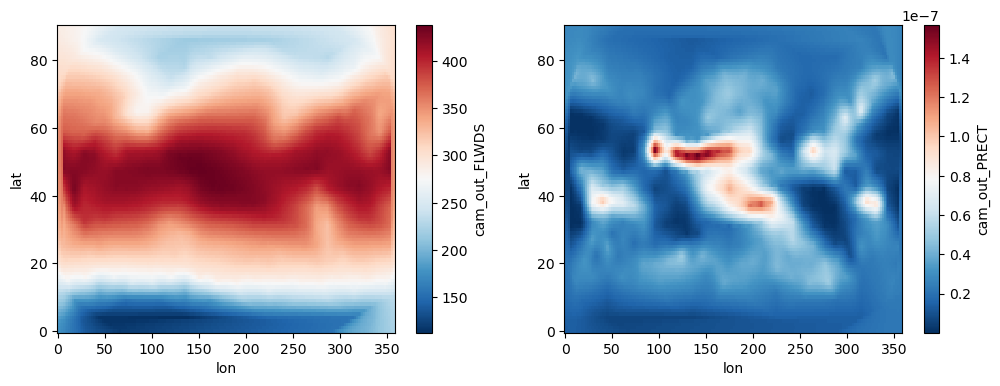

In [50]:
data_prect = data_var.copy()
data_flwds = data_var.copy()

# interpolate the data using pyngl
# optional: use multiprocessing to save the running time

for it, tt in enumerate(ds.time):
    data = ds.sel(time=tt).cam_out_FLWDS.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_flwds[it,:] = iarr
    
    data = ds.sel(time=tt).cam_out_PRECT.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_prect[it,:] = iarr

ds_new['cam_out_FLWDS'].values = data_flwds
ds_new['cam_out_PRECT'].values = data_prect

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_new['cam_out_FLWDS'].mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_new['cam_out_PRECT'].mean('time').plot(cmap='RdBu_r',ax=ax[1])

The precipitation map looks more realistic.

### <span style="color:blue"> I only finished processing the 2D variables please follow the above cell and create an interpolated dataset for one or a few 3D variables with "lev" dimension </span>.
### <span style="color:blue"> You do not need to show all the variables, use any of "state_t", "state_u" or "state_q0001" would be fine </span>.

In [ ]:
##### to be implemented...




### [Task 1] Replace the *lev* dimension with *pressure*

### <span style="color:blue"> Ask Sungduk about how to use P0 hyam hybm hybi hyai to calculate pressure. At this moment, you can ignore this task and just use "lev" as the vertical coordinate for the following tutorial</span>.



In [ ]:
##### to be implemented...




## Now, analysis and visualization can be done as usual using xarray


#### [Analysis 1] Global Precipitation 

We can use the original dataset to calculate global mean time series.

Note it should be the weighted average mean based on the area of each atmos grid/column.

The unit for precipitation is m/s.

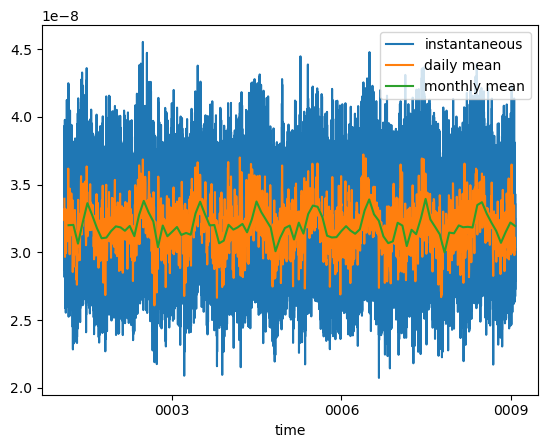

In [110]:
ds = xr.merge([ds_grid, ds])

# total precipitation = rainfall + snowfall
PRECT = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']

# area-weighted global mean PRECT
# required concept: avg weights, broadcast, resampling
PRECT_mean = (PRECT * (ds['area']/ds['area'].sum())).sum('ncol')
PRECT_mean_daily = PRECT_mean.resample(time='1D').mean('time')
PRECT_mean_monthly = PRECT_mean.resample(time='1M').mean('time')

# visualization
fig, ax = plt.subplots()
PRECT_mean.plot(label='instantaneous', ax=ax)
PRECT_mean_daily.plot(label='daily mean', ax=ax)
PRECT_mean_monthly.plot(label='monthly mean', ax=ax)
ax.legend()

Or, we can use use the processed dataset. In this case, we need to calculate the area of each 2x2 degree grid. There should be more than one way to do it.

#### [Task 2] Please calculate global mean precipitation using the processed dataset.

In [ ]:
##### to be implemented...
